In [120]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
import pandas as pd
import numpy as np
# plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# clf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import BernoulliNB

# preprocessing
from sklearn.preprocessing import Normalizer, MinMaxScaler

# evaluation
from sklearn.model_selection import cross_val_score, train_test_split
# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [196]:
paramspace = {
        'nb' : {'alpha': hp.uniform('alpha', 0.0, 2.0),
                'prep': hp.choice('prep', [0, 1, 2])},
    
        'svm': {'C': hp.loguniform('C', 0, 20),
                'kernel': hp.choice('kernel', ['linear', 'sigmoid', 'poly', 'rbf']),
                'gamma': hp.uniform('gamma', 0, 10),
                'prep': hp.choice('prep', [0, 1, 2])},
    
        'dt' : {
                'max_depth': hp.choice('max_depth', range(1,20)),
                'max_features': hp.choice('max_features', range(1,5)),
                'criterion': hp.choice('criterion', ["gini", "entropy"]),
                'prep': hp.choice('prep', [0, 1, 2])
                },
    
        'knn': {'n_neighbors': hp.choice('n_neighbors', range(1,20)),
                'prep': hp.choice('prep', [0, 1, 2])},
    
        'rf':{'max_depth': hp.choice('max_depth', range(1,20)),
              'max_features': hp.choice('max_features', range(1,5)),
              'n_estimators': hp.choice('n_estimators', range(1,20)),
              'criterion': hp.choice('criterion', ["gini", "entropy"]),
              'prep': hp.choice('prep', [0, 1, 2])},
         }



In [3]:
# preprocessing: prep
def normalize(X_):
    norm=Normalizer()
    X_ =norm.fit_transform(X_)
    return X_
def scale(X_):
    norm=MinMaxScaler()
    X_ =norm.fit_transform(X_)
    return X_

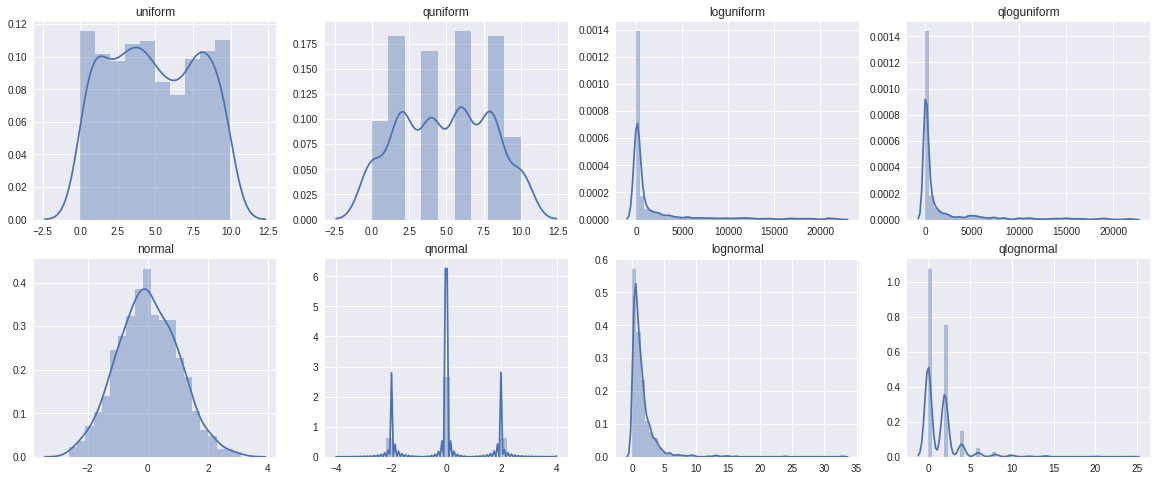

In [195]:
import hyperopt.pyll.stochastic
space = [{'uniform': hp.uniform('uniform', 0, 10)},
         {'quniform': hp.quniform('quniform', 0, 10, 2)},
         {'loguniform': hp.loguniform('loguniform', 0, 10)},
         {'qloguniform': hp.qloguniform('qloguniform', 0, 10, 1)},
         {'normal': hp.normal('normal',0, 1)},
         {'qnormal': hp.qnormal('qnormal',0, 1, 2)},
         {'lognormal': hp.lognormal('lognormal', 0, 1)},
         {'qlognormal': hp.qlognormal('qlognormal', 0, 1, 2)}
        ]

fig, ax = plt.subplots(2,4,figsize=(20,8))
for i,disttype in enumerate(space):
    #print i, disttype
    data = [hyperopt.pyll.stochastic.sample(disttype)[disttype.keys()[0]] for j in range(1000)]
    #print data[:10]
    sns.distplot(data, ax = ax[i/4][i%4])
    ax[i/4][i%4].set_title(disttype.keys()[0])
#hyperopt.pyll.stochastic.sample(space)

In [197]:
def paramHyperOpt(X, y, clfname):
    #clfname='rf'
    space=paramspace[clfname]

    def f(params):
        if 'prep' in params:
            if params['prep'] == 1: # 1: 'Normalizer'
                X_ = normalize(X)
            elif params['prep'] == 2: # 2: 'MinMaxScaler'
                X_ = scale(X)
        del params['prep']

        if clfname == 'nb':
            clf = BernoulliNB(**params)
        elif clfname == 'svm':
            clf = SVC(**params)
        elif clfname == 'dt':
            clf = DecisionTreeClassifier(**params)
        elif clfname == 'knn':
            clf = KNeighborsClassifier(**params)
        elif clfname == 'rf':
            clf =  RandomForestClassifier(**params)

        acc = cross_val_score(clf, X, y).mean()
        return {'loss': -acc, 'status': STATUS_OK}

    trials = Trials()
    best = fmin(f, space, algo=tpe.suggest, max_evals=100, trials=trials)
    #print ('best:')
    #print (best)
    return trials, best

{'kernel': 'rbf', 'C': 5.5931226618766905, 'prep': 0, 'gamma': 2.3376011682427054}


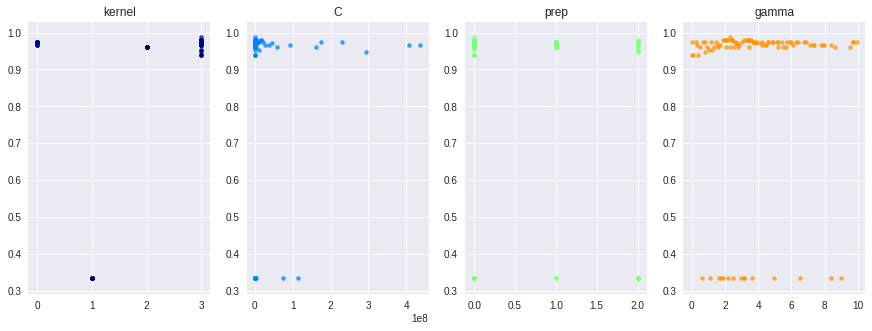

In [199]:
# plot "params vs loss"
clfname = 'svm'
trials, best = paramHyperOpt(X, y, clfname)
print space_eval(paramspace[clfname], best)

parameters = (paramspace[clfname]).keys()
cols = len(parameters)
f, axes = plt.subplots(nrows=1, ncols=cols, figsize=(15,5))
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    axes[i].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75, c=cmap(float(i)/len(parameters)))
    axes[i].set_title(val)

In [102]:
def bestParamsclf(X, y, best, clfname):
    params = space_eval(paramspace[clfname], best)
    if 'prep' in params:
        if params['prep'] == 1: # 1: 'Normalizer'
            X_ = normalize(X)
        elif params['prep'] == 2: # 2: 'MinMaxScaler'
            X_ = scale(X)
        else:
            X_ =X
    del params['prep']
    
    if clfname == 'nb':
        clf = BernoulliNB(**params)
    elif clfname == 'svm':
        clf = SVC(**params)
    elif clfname == 'dt':
        clf = DecisionTreeClassifier(**params)
    elif clfname == 'knn':
        clf = KNeighborsClassifier(**params)
    elif clfname == 'rf':
        clf =  RandomForestClassifier(**params)
    return X_, y, clf

#X_, y, clf= bestParamsclf(best,clfname)

In [2]:
# dataset
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

clfnames = ['nb','svm','dt','knn','rf']
res=[]
resdict={}

for clfname in clfnames:
    print clfname
    _, bestparams =paramHyperOpt(X_train, y_train, clfname)
    params = space_eval(paramspace[clfname], bestparams)
    
    X_train, y_train, clf= bestParamsclf(X_train, y_train, bestparams, clfname)
    X_test, y_test, clf= bestParamsclf(X_test, y_test, bestparams, clfname)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    resdict={}
    resdict['clfname'] = clfname
    resdict['params'] = params
    resdict['acc'] = accuracy_score(y_test, y_pred)
    res.append(resdict)
resdf= pd.DataFrame(res)
resdf

,acc,clfname,params
0,0.333333,nb,"{u'alpha': 0.821930424188, u'prep': 1}"
1,0.983333,svm,"{u'kernel': u'rbf', u'C': 0.502706736602, u'pr..."
2,0.933333,dt,"{u'max_features': 2, u'criterion': u'gini', u'..."
3,0.950000,knn,"{u'n_neighbors': 18, u'prep': 2}"
4,0.983333,rf,"{u'max_features': 4, u'n_estimators': 19, u'cr..."


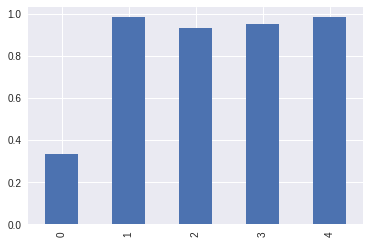

In [132]:
resdf['acc'].plot(kind='bar')

In [119]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        20
          1       0.95      1.00      0.98        20
          2       1.00      0.95      0.97        20

avg / total       0.98      0.98      0.98        60

